In [1]:
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np


In [2]:
import matplotlib.pyplot as plt

In [8]:

import random
import os

#generator image from directory
import matplotlib.pyplot as plt

#list of samples from directory
def list_data(path_data,teg):
    List_samples = os.listdir(path_data)
    #print(List_samples[:2])
    List_ = [os.path.join(path_data, file_i) for file_i in List_samples]
    #print(List_[:2])
    List_teg = [teg]*len(List_)
    return List_,List_teg

def create_dataset_generator_srgan(list_dir,teg, hsv_=0):
    '''
    input:
        list_dir - list of file's name
        teg - list of label
    return^
    image, image - pair preprocess image and image (image == image)   
    '''
    def argument_free_generator():
        for inp, label in zip(list_dir, teg):
            image = preprocess_p(inp, hsv_=hsv_)
            
            yield image*5,label
    return argument_free_generator

In [4]:
def preprocess_p(path,model_p = '', hsv_=0):
    '''
    get square crop from image? and resize to SIZE
    input:
        path - image file path + file name
        SIZE - image size

    return: image in SIZE
    '''

    # read item
    #print(path)
    image_bytes = tf.io.read_file(path)
    #print(image_bytes.shape)
    image = tf.image.decode_image(image_bytes)
    #print(image.numpy().shape)
    image = tf.cast(image[ :, :, :3] / 255, dtype=tf.float32)
    if hsv_:
        image = tf.image.hsv_to_rgb(image)
    #print(image.numpy().max())
    #image = tf.reshape(image,shape = [ None, None, 3])
    # augmentation
    #image = tf.image.resize(image, size = [224,224])
    initial_width = tf.shape(image)[1]
    initial_height = tf.shape(image)[0]
    
    
    h2 = initial_height.numpy() // 2
    w2 = initial_width.numpy() // 2
    image = tf.image.crop_to_bounding_box(image, 0, 0, (h2 // 2) * 4, (w2 // 2) * 4)
    image_lr = tf.image.resize(image,[h2//2,w2//2], method = 'bicubic')
    
    image_lr = tf.cast(tf.reshape(image_lr,[1,h2//2,w2//2,3]), dtype = tf.float32)
    #print(image_lr.shape)
    
    image_hr = tf.cast(tf.image.resize(image_lr,[h2*2,w2*2]), dtype = tf.float32) #model_p(image_lr)
    #print(image.shape,image_hr.shape)
    image = image - image_hr[0,:,:,:]
    #print(image.shape)
    #print(h2,w2)
    delta = tf.math.abs(h2 -w2).numpy() * 2
    #print(delta)
    if delta>0:
        d = np.random.randint(0,delta // 2,1)[0]
    else:
        d = 0
    #print(image.shape, h2,w2,d)
    if initial_height>initial_width:
        #rint(d,d+w2*2)
        image = image[d:d+w2*2,:,:]
    else:
        #print('2:',d,d+h2*2)
        image = image[:,d:d+h2*2,:]
    #print(image.shape)
    
    #print(image.shape)
    return tf.image.resize(image , size = [224,224]).numpy()


In [9]:
hsv_=1
batch_size_model = 16
if 1:
    list_ok_val, teg_ok_val = list_data('/home/ubuntu/test_/data/ok_val',0)
    list_attack_val, teg_a_val = list_data('/home/ubuntu/test_/data/attack_val',1)
    #train set
    list_ok, teg_ok = list_data('/home/ubuntu/test_/data/ok',0)
    list_attack, teg_a = list_data('/home/ubuntu/test_/data/attack',1)
else:
    list_ok_val, teg_ok_val = list_data('/home/mariya/Рабочий стол/face_antispoofing_dev/data_for_Maria/Ok',0)
    list_attack_val, teg_a_val = list_data('/home/mariya/Рабочий стол/face_antispoofing_dev/data_for_Maria/attack',1)
    #train set
    list_ok, teg_ok = list_data('/home/mariya/Рабочий стол/face_antispoofing_dev/data_for_Maria/Ok',0)

    list_attack, teg_a = list_data('/home/mariya/Рабочий стол/face_antispoofing_dev/data_for_Maria/attack',1)
# kirill set
if 0:

    list_ok += list_mob0+list_desk0
    teg_ok = [0]*len(list_ok)
    list_attack += list_mob1+list_desk1
    teg_a = [1]*len(list_attack)
    

# load all model and all dataset

N = 10
Nt = 150#n_test*batch_size_model

# train list of files (only Ok)

list_train,teg_train = np.array(list_ok+list_attack),np.array([0]*len(list_ok)+[1]*len(list_attack))
list_train,teg_train = np.array(list_train[::N]),np.array(teg_train[::N])

#shuffle samples
ind = np.arange(len(list_train))
np.random.shuffle(ind)
ind = ind.tolist()
list_train, teg_train = list_train[ind], teg_train[ind]

#create data generator (image, image)
G_train = create_dataset_generator_srgan(list_train[::N].tolist(),teg_train[::N].tolist(),hsv_=hsv_)
G_test = create_dataset_generator_srgan( list_ok_val[::Nt]+list_attack_val[::Nt],[0]*len(list_ok_val[::Nt])+[1]*len(list_attack_val[::Nt]),hsv_=hsv_)

train_ds = tf.data.Dataset.from_generator(G_train, (tf.float32, tf.float32), ((224,224,3 ), ()))
test_ds = tf.data.Dataset.from_generator(G_test, (tf.float32, tf.float32), ((224,224,3 ), ()))
# By default you 'run out of data', this is why you repeat the dataset and serve data in batches.
train_ds = train_ds.repeat().batch(batch_size_model)
test_ds = test_ds.batch(batch_size_model)    


In [10]:
for ll in train_ds.take(5):
    I = ll[0]#preprocess_p(ll,model_p = model, hsv_=0)
    #plt.imshow(I[0,:,:,:])
    #plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/home/ubuntu/test_/data/ok/46be9064-353f-4250-abc1-1129b4b599aa.mp4.0001.jpg


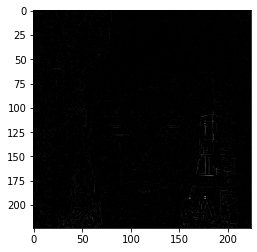

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/home/ubuntu/test_/data/attack/14537714-eea0-4f46-aa6a-0f9c6bfca4bc.mp4.0024.jpg


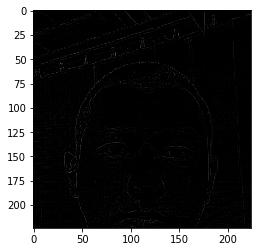

In [11]:
for ll in list_train[3:5]:
    print(ll)
    I = preprocess_p(ll,model_p = '', hsv_=0)
    plt.imshow(I[:,:,:])
    plt.show()

In [12]:
I.max()

0.37767127

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


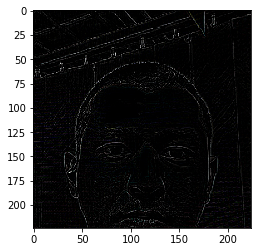

In [13]:
plt.imshow(I[:,:,:]/I.max())
plt.show()

In [14]:

#print(argv)
#pp, pp1,pp =2, pp3 = argv
pp1,pp2, pp3 = 128,'','' 
latent_dim_ = int(pp1)



m = 1

def auto_d( kernel_num_enc = [64,128,192,64,128],kernel_size_enc=[3,3,3,4,1],stride_enc = [2,2,2,1,1],act_enc =['relu']*5,
                kernel_num_dec = [64,64,64,32,3],kernel_size_dec=[4,3,3,3,3],stride_dec = [1,2,2,2,1], act_dec = [tf.keras.layers.LeakyReLU(alpha=0.5)]*4+['tanh']):
    print(': autoD:')
    x_in = tf.keras.layers.Input(shape=(224,224,3))
    print(x_in.shape)
    #list_scip = [x]
    x = x_in
    for i in range(len(kernel_num_enc)-1):
        print(':')
        x = tf.keras.layers.Conv2D(kernel_num_enc[i],(kernel_size_enc[i],kernel_size_enc[i]),strides = (stride_enc[i],stride_enc[i]), activation=act_enc[i],padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        #list_scip +=[x]
        #print(x.shape)
        #x = keras.layers.Concatenate()([x,list_scip[-2]])
    print(':::',x.shape)
    x = tf.keras.layers.Conv2D(kernel_num_enc[-2]*2,(3,3),strides = (1,1),padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.5)(x)

    x = tf.keras.layers.Conv2D(kernel_num_enc[-2]*2,(3,3),strides = (1,1),padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.5)(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    #print(x.shape,list_scip[i].shape)
    x = tf.keras.layers.Dense(kernel_num_enc[-1],activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x_out = tf.keras.layers.Dense(1,activation = 'sigmoid')(x)
    print(':',x_out.shape)
    model = tf.keras.Model(x_in, x_out)
    #model.summary()
    return model

In [15]:
def auto_dm( kernel_num_enc = [64,128,192,64,128],kernel_size_enc=[3,3,3,4,1],stride_enc = [2,2,2,1,1],act_enc =['relu']*5,
                kernel_num_dec = [64,64,64,32,3],kernel_size_dec=[4,3,3,3,3],stride_dec = [1,2,2,2,1], act_dec = [tf.keras.layers.LeakyReLU(alpha=0.5)]*4+['tanh']):
    print(': autoD:')
    x_in = tf.keras.layers.Input(shape=(224,224,3))
    print(x_in.shape)
    #list_scip = [x]
    model_base = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=[224,224,3],
    alpha=1.4,
    include_top=False,
    weights='imagenet')
    x = x_in
    x = model_base(x_in)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    #print(x.shape,list_scip[i].shape)
    x = tf.keras.layers.Dense(kernel_num_enc[-1],activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x_out = tf.keras.layers.Dense(1,activation = 'sigmoid')(x)
    print(':',x_out.shape)
    model = tf.keras.Model(x_in, x_out)
    #model.summary()
    return model

In [19]:

STEPS_PER_EPOCH = len(list_train) // batch_size_model
checkpoint_filepath= 'model/checkpoints/srgan'
model_name ='rez_class_mob'
# new train cycle

cb_tensorboard = tf.keras.callbacks.TensorBoard(log_dir=checkpoint_filepath + "/"+model_name, histogram_freq=0, write_graph=False, profile_batch=0,
                                                        write_images=False)

cb_last = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath +"/"+model_name+".hdf5")
cb_best_loss = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath + "/"+model_name+".best.{epoch:04d}-{val_loss:.4f}-{val_loss:.4f}.hdf5",
        monitor="val_loss",save_best_only=True, save_weights_only=False)
cb_periodic = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath + "/"+model_name+".period.{loss:.4f}-{loss:.4f}.hdf5",
        save_weights_only=False, save_freq=100)

k = 1
initial_epoch = 0

h_model = []
epoch = 1
n = 1
srgan = auto_dm()#generator_model=Generator(),
#discriminator_model=Discriminator())
#srgan.generator_model.build((1,None,None,3))
test_image_height = 224
test_image_width = 224
channels = 3
print('train:',len(list_train))
cb_periodic = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath + "/p_"+model_name,
                                                 save_weights_only=False, save_freq=100)


: autoD:
(None, 224, 224, 3)
: (None, 1)
train: 38066


In [20]:

for i in range(2):
    learning_rate = tf.optimizers.schedules.PiecewiseConstantDecay(boundaries=[4000 / 2], values=[0.0001, 0.00001])
    h = srgan.compile(optimizer = tf.keras.optimizers.Adam(learning_rate),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    srgan.fit(train_ds,steps_per_epoch= STEPS_PER_EPOCH,
              callbacks = [cb_periodic], validation_data=(test_ds))
    if 1:
        srgan.save(checkpoint_filepath + "/"+model_name+'class_genG_SRGAN.hdf5')

    else:
        srgan.save(checkpoint_filepath + "/p_"+model_name+'class_genG_SRGAN.hdf5')
else:#except:
    print('no model')

2379/2379 [==============================] - 1144s 479ms/step - loss: 0.0891 - accuracy: 0.9664 - val_loss: 0.8693 - val_accuracy: 0.7445
no model
